In [14]:
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
import scipy.sparse as sparse
import itertools
import copy
import implicit
import matplotlib.pyplot as plt

In [2]:
import feather

In [3]:
file_path = 'sample.csv'
df = pd.read_csv(file_path, index_col='Unnamed: 0')
# df.info(null_counts=True)

/home/suils789/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### I. generate sparse matrix with DiGraph
+ [improvement] might be better with coo matrix
+ could be faster with spark VectorAssembler

In [4]:
# sampling there might be better way to do it
df = df.sample(100000)
users = df['uuid'].values
traits = [eval(x) for x in df['encodedTraits.indices'].values]

In [5]:
# find unique traits
item = [ele for x in df['encodedTraits.indices'].values for ele in eval(x)]

In [6]:
item_size = len(set(item))
print("unique items are {}".format(item_size))

unique items are 4351


### II. Implicit ALS

The model works as the following:
if we define a user preference of the trait as $p_{ui} \epsilon {0,1}$ for 0 as no observing trait in the user row, 1 as the trait is consumed. By adding a confidence term in front of the regular loss, it usually performs well for implicit data.

Note That: I am trying to modify the loss in python, since it's not hard to implement ALS. But I am not sure how should I rewrite it that penalize more if two vectors have non-zero entry at different position

+ Train Test Split to tune the model and get the best latent space base on hamming distance (currently mse)
+ Plot Clustering on latent space


i. Methodology

a. Train Validation Split

One way to treat the problem is to assume user behavior is according to their preference, the reason of users consume the trait has the same underline latent preference with their previous browsing. So that if the model can find the most similar trait and user preference latent space, then it would be a fair presentation in lower dimension. In other words, if the model can successfully predict the most similar trait in validation set for users(using hamming distance), then it could be good at capture the user vectors.

Due to the nature of matrix factorization requires all users and traits presented in the model. Need to carefully decide the split of test data from train. Here I randomly select 20% user (>= 2 traits) and take one observation to test set and mask the history in train.

There is some limination to the approach. I might take out valuable information and the model failed to capture for users. Better way might be split across time.

b. Evaluation Metrics (to be added after update)

In [7]:
# create bipartile graph
B = nx.DiGraph()
B.add_nodes_from(users, bipartite=0)
B.add_nodes_from(list(range(1,item_size+1)), bipartite=1)
# add edge 
for i in range(len(users)):
    for j in range(len(traits[i])):
        B.add_edge(users[i], traits[i][j])
user_traits_matrix = bipartite.matrix.biadjacency_matrix(B, users, list(range(1,item_size+1)))

user_traits_matrix = user_traits_matrix.astype(np.float32)
# each row as user, each col as item

In [8]:
user_traits_matrix

<100000x4351 sparse matrix of type '<class 'numpy.float32'>'
	with 788980 stored elements in Compressed Sparse Row format>

In [9]:
def train_test_split(ratings, split_count, fraction=None):
    """
    Split recommendation data into train and test sets
    
    Params
    ------
    ratings : scipy.sparse matrix
        Interactions between users and items.
    split_count : int
        Number of user-item-interactions per user to move
        from training to test set.
    fractions : float
        Fraction of users to split off some of their
        interactions into test set. If None, then all 
        users are considered.
    """
    train = ratings.copy().tocoo()
    test = sparse.lil_matrix(train.shape)
    
    if fraction:
        try:
            user_index = np.random.choice(
                np.where(np.bincount(train.row) >= split_count * 2)[0], 
                replace=False,
                size=np.int32(np.floor(fraction * train.shape[0]))
            ).tolist()
        except:
            print(('Not enough users with > {} '
                  'interactions for fraction of {}')\
                  .format(2*k, fraction))
            raise
    else:
        user_index = range(train.shape[0])
        
    train = train.tolil()

    for user in user_index:
        test_ratings = np.random.choice(ratings.getrow(user).indices, 
                                        size=split_count, 
                                        replace=False)
        train[user, test_ratings] = 0.
        # These are just 1.0 right now
        test[user, test_ratings] = ratings[user, test_ratings]
   
    
    # Test and training are truly disjoint
    assert(train.multiply(test).nnz == 0)
    return train.tocsr(), test.tocsr(), user_index

In [10]:
user_traits_matrix = user_traits_matrix.tocsr()
train, test, user_index = train_test_split(user_traits_matrix, 1, fraction=0.2)
train,test,len(user_index)

(<100000x4351 sparse matrix of type '<class 'numpy.float32'>'
 	with 768980 stored elements in Compressed Sparse Row format>,
 <100000x4351 sparse matrix of type '<class 'numpy.float64'>'
 	with 20000 stored elements in Compressed Sparse Row format>,
 20000)

In [11]:
# Evaluation Metrics 
# to be substitude by hamming distance from Aditya
from sklearn.metrics import mean_squared_error
def calculate_mse(model, ratings, user_index=None):
    preds = np.nan_to_num(np.dot(model.user_factors,model.item_factors.T)) 
    return mean_squared_error(ratings.toarray().ravel(),
                              preds.ravel())

In [12]:
def precision_at_k(model, ratings, k=1, user_index=None, use_test=True):
    test_user = ratings.nonzero()[0]
    labels = ratings.nonzero()[1]
    precisions = []
    for i, userid in enumerate(test_user):
        if use_test:
            hotel_ind = model.recommend(userid, train.tocsr(), N=1)[0][0]
        else:
            user_latent = model.user_factors[userid,:]
            hotel_ind = np.argsort(user_latent.dot(model.item_factors.T))[::-1][:1]
        precisions.append(hotel_ind==labels[i])
    return np.mean(precisions)   

In [13]:
def print_log(row, header=False, spacing=12):
    top = ''
    middle = ''
    bottom = ''
    for r in row:
        top += '+{}'.format('-'*spacing)
        if isinstance(r, str):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif isinstance(r, int):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif isinstance(r, float):
            middle += '| {0:^{1}.5f} '.format(r, spacing-2)
        bottom += '+{}'.format('='*spacing)
    top += '+'
    middle += '|'
    bottom += '+'
    if header:
        print(top)
        print(middle)
        print(bottom)
    else:
        print(middle)
        print(top)

In [14]:
def learning_curve(model, train, test, k=5, user_index=None):
    if not user_index:
        user_index = range(train.shape[0])
    train_precision = []
    train_mse = []
    test_precision = []
    test_mse = []
    
    headers = ['p@k train', 'p@k test',
               'mse train', 'mse test']
    print_log(headers, header=True)
    model.fit(train.T)
    train_mse.append(calculate_mse(model, train, user_index))
    train_precision.append(precision_at_k(model, train, k, user_index, use_test=False))
    test_mse.append(calculate_mse(model, test, user_index))
    test_precision.append(precision_at_k(model, test, k, user_index))
    row = [train_precision[-1], test_precision[-1],
               train_mse[-1], test_mse[-1]]
    print_log(row)
    return model, train_precision, train_mse, test_precision, test_mse

In [15]:
def grid_search_learning_curve(base_model, train, test, param_grid,
                               user_index=None, patk=5):
    curves = []
    keys, values = zip(*param_grid.items())
    for v in itertools.product(*values):
        params = dict(zip(keys, v))
        this_model = copy.deepcopy(base_model)
        print_line = []
        for k, v in params.items():
            setattr(this_model, k, v)
            print_line.append((k, v))

        print(' | '.join('{}: {}'.format(k, v) for (k, v) in print_line))
        _, train_patk, train_mse, test_patk, test_mse = learning_curve(this_model, train, test, k=patk, user_index=user_index)
        curves.append({'params': params,
                       'patk': {'train': train_patk, 'test': test_patk},
                       'mse': {'train': train_mse, 'test': test_mse}})
    return curves


In [16]:
!export OPENBLAS_NUM_THREADS=1
param_grid = {'factors': [10, 20, 40, 50],
              'regularization': [1e-2, 1e1, 1e2]}

base_model = implicit.als.AlternatingLeastSquares(calculate_training_loss=True)

curves = grid_search_learning_curve(base_model, train, test,
                                    param_grid,
                                    user_index=user_index,
                                    patk=1)

  0%|          | 0/15 [00:00<?, ?it/s]

factors: 10 | regularization: 0.01
+------------+------------+------------+------------+
| p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+


100%|██████████| 15.0/15 [00:09<00:00,  1.74it/s, loss=0.000631]
  0%|          | 0/15 [00:00<?, ?it/s]

|  0.12881   |  0.42425   |  0.00117   |
+------------+------------+------------+------------+
factors: 10 | regularization: 10.0
+------------+------------+------------+------------+
| p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+


100%|██████████| 15.0/15 [00:09<00:00,  1.56it/s, loss=0.000709]
  0%|          | 0/15 [00:00<?, ?it/s]

|  0.12881   |  0.42520   |  0.00109   |
+------------+------------+------------+------------+
factors: 10 | regularization: 100.0
+------------+------------+------------+------------+
| p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+


100%|██████████| 15.0/15 [00:09<00:00,  1.81it/s, loss=0.00122]
  0%|          | 0/15 [00:00<?, ?it/s]

|  0.12866   |  0.52440   |  0.00057   |
+------------+------------+------------+------------+
factors: 20 | regularization: 0.01
+------------+------------+------------+------------+
| p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+


100%|██████████| 15.0/15 [00:11<00:00,  1.45it/s, loss=0.000562]
  0%|          | 0/15 [00:00<?, ?it/s]

|  0.12945   |  0.09095   |  0.00125   |
+------------+------------+------------+------------+
factors: 20 | regularization: 10.0
+------------+------------+------------+------------+
| p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+


100%|██████████| 15.0/15 [00:11<00:00,  1.50it/s, loss=0.000662]
  0%|          | 0/15 [00:00<?, ?it/s]

|  0.12946   |  0.44605   |  0.00115   |
+------------+------------+------------+------------+
factors: 20 | regularization: 100.0
+------------+------------+------------+------------+
| p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+


100%|██████████| 15.0/15 [00:11<00:00,  1.26it/s, loss=0.00122]
  0%|          | 0/15 [00:00<?, ?it/s]

|  0.12866   |  0.52450   |  0.00057   |
+------------+------------+------------+------------+
factors: 40 | regularization: 0.01
+------------+------------+------------+------------+
| p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+


100%|██████████| 15.0/15 [00:19<00:00,  1.09s/it, loss=0.000489]
  0%|          | 0/15 [00:00<?, ?it/s]

|  0.12993   |  0.08190   |  0.00132   |
+------------+------------+------------+------------+
factors: 40 | regularization: 10.0
+------------+------------+------------+------------+
| p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+


100%|██████████| 15.0/15 [00:18<00:00,  1.05s/it, loss=0.000622]
  0%|          | 0/15 [00:00<?, ?it/s]

|  0.12993   |  0.39350   |  0.00119   |
+------------+------------+------------+------------+
factors: 40 | regularization: 100.0
+------------+------------+------------+------------+
| p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+


100%|██████████| 15.0/15 [00:18<00:00,  1.06s/it, loss=0.00122]
  0%|          | 0/15 [00:00<?, ?it/s]

|  0.12866   |  0.52465   |  0.00057   |
+------------+------------+------------+------------+
factors: 50 | regularization: 0.01
+------------+------------+------------+------------+
| p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+


100%|██████████| 15.0/15 [00:23<00:00,  1.35s/it, loss=0.000464]
  0%|          | 0/15 [00:00<?, ?it/s]

|  0.12994   |  0.05885   |  0.00135   |
+------------+------------+------------+------------+
factors: 50 | regularization: 10.0
+------------+------------+------------+------------+
| p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+


100%|██████████| 15.0/15 [00:23<00:00,  1.34s/it, loss=0.000609]
  0%|          | 0/15 [00:00<?, ?it/s]

|  0.12994   |  0.39245   |  0.00121   |
+------------+------------+------------+------------+
factors: 50 | regularization: 100.0
+------------+------------+------------+------------+
| p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+


100%|██████████| 15.0/15 [00:23<00:00,  1.32s/it, loss=0.00122]


|  0.12866   |  0.52465   |  0.00057   |
+------------+------------+------------+------------+


In [17]:
best_curves = sorted(curves, key=lambda x: max(x['patk']['test']), reverse=True)
print(best_curves[0]['params'])
max_score = max(best_curves[0]['patk']['test'])
print(max_score)

{'factors': 40, 'regularization': 100.0}
0.52465


In [18]:
curves

[{'mse': {'test': [0.0011679920720180724], 'train': [0.0006284683]},
  'params': {'factors': 10, 'regularization': 0.01},
  'patk': {'test': [0.42425], 'train': [0.1288095919269682]}},
 {'mse': {'test': [0.0010944368688379327], 'train': [0.0006306074]},
  'params': {'factors': 10, 'regularization': 10.0},
  'patk': {'test': [0.4252], 'train': [0.1288108923509064]}},
 {'mse': {'test': [0.0005748749216924054], 'train': [0.000854836]},
  'params': {'factors': 10, 'regularization': 100.0},
  'patk': {'test': [0.5244], 'train': [0.12866394444588936]}},
 {'mse': {'test': [0.0012499418333243421], 'train': [0.0005588222]},
  'params': {'factors': 20, 'regularization': 0.01},
  'patk': {'test': [0.09095], 'train': [0.1294546022003173]}},
 {'mse': {'test': [0.0011515402474734347], 'train': [0.0005634215]},
  'params': {'factors': 20, 'regularization': 10.0},
  'patk': {'test': [0.44605], 'train': [0.12945590262425552]}},
 {'mse': {'test': [0.0005749264098628777], 'train': [0.0008547313]},
  'par

### Best Model by mse on DataSet 
+ better metrics calc. for gridsearch

In [5]:
df = pd.read_csv("sample.csv",index_col='Unnamed: 0').drop_duplicates(subset = 'uuid')
users = df['uuid'].values
traits = [eval(x) for x in df['encodedTraits.indices'].values]
B = nx.DiGraph()
B.add_nodes_from(users, bipartite=0)
B.add_nodes_from(list(range(1,5198)), bipartite=1)
for i in range(len(users)):
    for j in range(len(traits[i])):
        B.add_edge(users[i], traits[i][j])
user_traits_matrix = bipartite.matrix.biadjacency_matrix(B, users, list(range(1,5198)))

/home/suils789/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [7]:
! export MKL_NUM_THREADS=1
# param = best_curves[0]['params']
als = implicit.als.AlternatingLeastSquares(factors=40, regularization=100, calculate_training_loss=True)
als.fit(user_traits_matrix.T.tocsr())

100%|██████████| 15.0/15 [03:35<00:00, 12.34s/it, loss=0.000853]


In [8]:
latent_space = als.user_factors
print(als.item_factors.shape)
print(als.user_factors.shape)

(5197, 40)
(1371486, 40)


In [37]:
#Kmeans clustering
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline  
import sklearn.metrics as metrics
def sc_evaluate_clusters(X,max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0;
    for k in range(2,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        s[k] = metrics.silhouette_score(X,kmeans.labels_,metric='cosine')
    plt.plot(range(2,len(s)),s[2:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

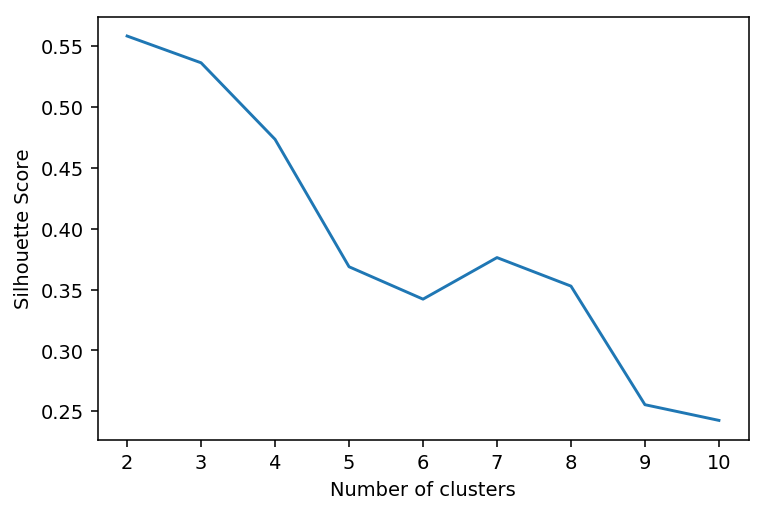

In [42]:
plt.rcParams['figure.dpi'] = 140
sc_evaluate_clusters(latent_space, 10)

In [85]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
dbs = KMeans(n_clusters=6, init='k-means++').fit(latent_space)

In [86]:
plt.rcParams['figure.dpi'] = 100

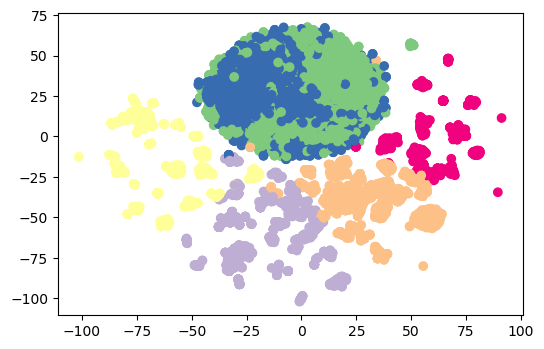

In [87]:
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, init='pca')
latent_space = tsne.fit_transform(als.user_factors[:10000])
plt.scatter(latent_space[:,0], latent_space[:,1], c=plt.cm.Accent(dbs.labels_[:10000]))
# plt.legend(handles=['cluster 0','cluster 1','cluster 2', 'cluster 3', 'cluster 4', 'cluster 5'])
plt.show()

In [82]:
kmeans = KMeans(n_clusters=5, init='k-means++').fit(latent_space)

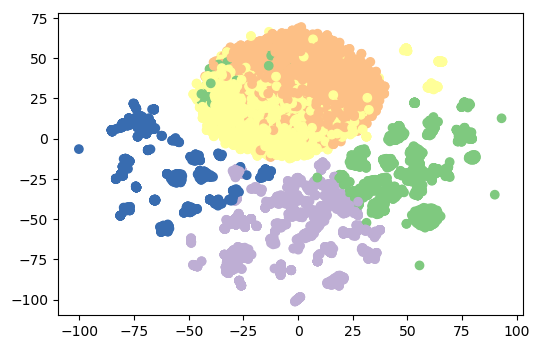

In [83]:
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, init='pca')
latent_space = tsne.fit_transform(als.user_factors[:10000])
plt.scatter(latent_space[:,0], latent_space[:,1], c=plt.cm.Accent(kmeans.labels_[:10000]))
# plt.legend(handles=['cluster 0','cluster 1','cluster 2', 'cluster 3', 'cluster 4', 'cluster 5'])
plt.show()

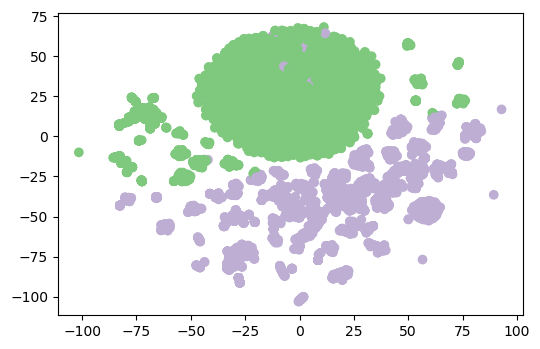

In [62]:
kmeans = KMeans(n_clusters=2, init='k-means++').fit(latent_space)
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, init='pca')
latent_space = tsne.fit_transform(als.user_factors[:10000])
plt.scatter(latent_space[:,0], latent_space[:,1], c=plt.cm.Accent(kmeans.labels_[:10000]))
# plt.legend(handles=['cluster 0','cluster 1','cluster 2', 'cluster 3', 'cluster 4', 'cluster 5'])
plt.show()

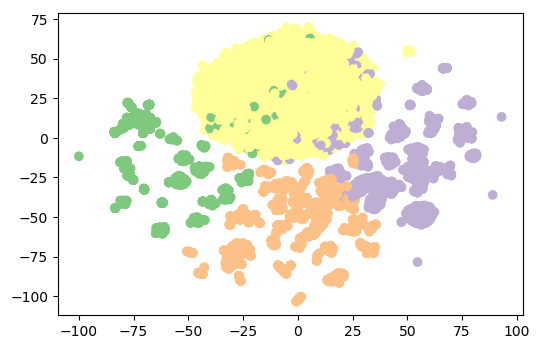

In [52]:
kmeans = KMeans(n_clusters=4, init='k-means++').fit(latent_space)
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, init='pca')
latent_space = tsne.fit_transform(als.user_factors[:10000])
plt.scatter(latent_space[:,0], latent_space[:,1], c=plt.cm.Accent(kmeans.labels_[:10000]))
plt.show()

### Default Model

In [ ]:
als = implicit.als.AlternatingLeastSquares(calculate_training_loss=True)
als.fit(user_traits_matrix.T.tocsr())

In [49]:
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, init='random')
latent_space = tsne.fit_transform(als.user_factors)

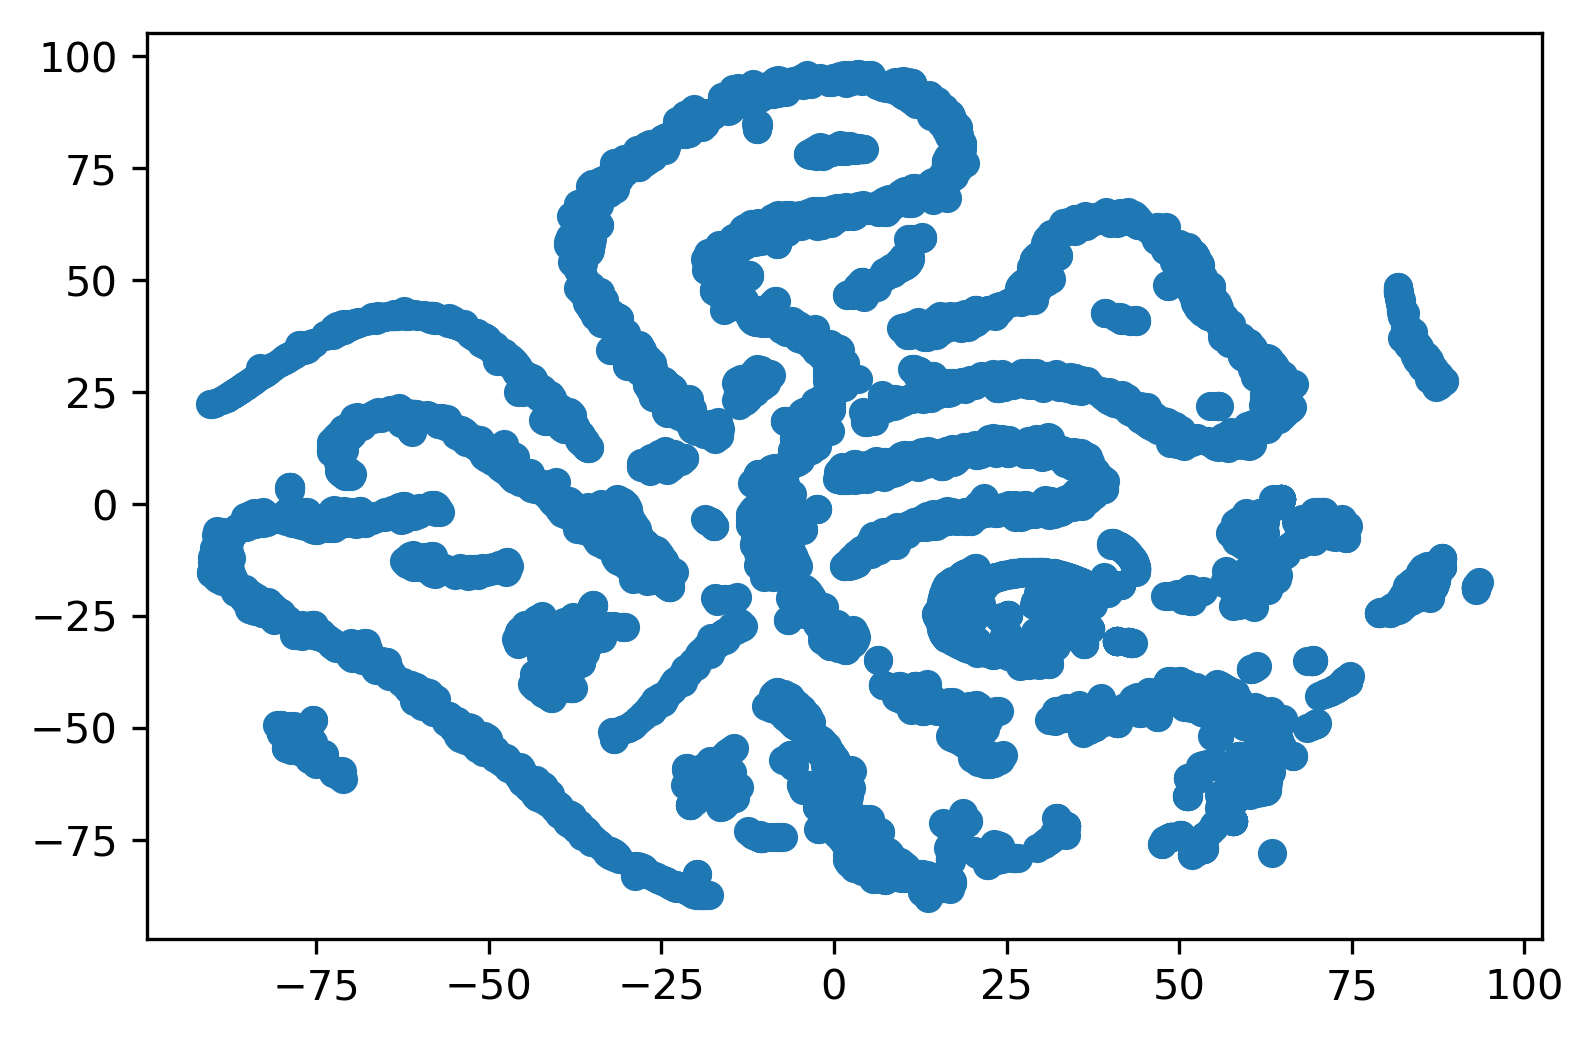

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = "300"
plt.scatter(latent_space[:,0], latent_space[:,1])